# CS:GO Professional Match Analysis
The dates of the matches range from 04/2017 to 03/2020.
Data from https://www.kaggle.com/datasets/mateusdmachado/csgo-professional-matches?resource=download&select=players.csv (This data was scraped off https://www.hltv.org/)
### Content
The data is split into 3 tables that store data related to:

Results.csv: map scores and team rankings
Economy.csv: round start equipment value for all rounds played
Players.csv: individual performances of players on each map.

Values stored in 'event_id' and 'match_id' columns are unique for each match and event and shared between tables, so these columns can be used as keys to merge data between tables.

Among all the data we will consider only matches of the top 30 teams according to the rating (at the time of the match) in accordance with the Hltv.org rating. On the main page (as an example https://www.hltv.org/ranking/teams/2024/june/24) only the top 30 teams are displayed, we will assume that these are tier-1 teams, the rest of the teams are too unstable.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
import pandas as pd
from scipy.stats import pearsonr
# Load the data from the CSV files
economy = pd.read_csv("economy.csv",low_memory=False)
results = pd.read_csv("results.csv")
players = pd.read_csv("players.csv")

### Our overall team statistics will include the following features:

- **date**: The date the match was played.
- **event_id**: A unique identifier for the tournament.
- **match_id**: A unique identifier for the match (a match between teams at a specific stage of the tournament, the same identifier regardless of the map).
- **rank_1**: The rank of the first team according to the HLTV.org ranking.
- **rank_2**: The rank of the second team according to the HLTV.org ranking.
- **team_1**: The name of the first team.
- **team_2**: The name of the second team.
- **_map**: The name of the map.
- **result_1**: The number of rounds won by the first team.
- **result_2**: The number of rounds won by the second team.
- **map_winner**: The winner of the map.
- **starting_ct**: The number of the team that started on the Counter-Terrorist side.
- **ct_1**: The number of rounds won by the first team on the Counter-Terrorist side.
- **t_2**: The number of rounds won by the second team on the Terrorist side.
- **t_1**: The number of rounds won by the first team on the Terrorist side.
- **ct_2**: The number of rounds won by the second team on the Counter-Terrorist side.
- **1_winner**: The winner of the first round (first pistol round).
- **2_winner**: The winner of the second round.
- **16_winner**: The winner of the first round in the second half (second pistol round, first round after teams switch sides).

   * the rest of the data will be extracted from these columns

In [2]:
# Filter the results DataFrame to include only the specified columns
results_filtered = results.loc[
    :, ['date', 'team_1', 'team_2', '_map', 'result_1', 'result_2', 'map_winner', 'starting_ct', 'ct_1', 't_2', 't_1', 'ct_2', 'event_id', 'match_id', 'rank_1', 'rank_2']
]

# Convert 'date' column to datetime format for filtering
results_filtered['date'] = pd.to_datetime(results_filtered['date'])

# Filter rows where rank_1 <= 30 and rank_2 <= 30 and date within the specified range
results_filtered = results_filtered.loc[
    (results_filtered['rank_1'] <= 30) & 
    (results_filtered['rank_2'] <= 30) & 
    (results_filtered['date'] >= '2017-04-04') & # data, pro která máme statistiky economy.csv
    (results_filtered['date'] <= '2020-03-01')
]

# Merge the economy DataFrame to include '1_winner' and '2_winner' columns based on 'event_id', 'match_id', '_map'
merged_results = pd.merge(
    results_filtered,
    economy[['event_id', 'match_id', '_map', '1_winner', '2_winner', '16_winner']],
    on=['event_id', 'match_id', '_map'],
    how='left'
)
# Drop rows with NaN values in '1_winner', '2_winner', and '16_winner'
merged_results = merged_results.dropna(subset=['1_winner', '2_winner', '16_winner'])

In [3]:
merged_results.head()

,date,team_1,team_2,_map,result_1,result_2,map_winner,starting_ct,ct_1,t_2,t_1,ct_2,event_id,match_id,rank_1,rank_2,1_winner,2_winner,16_winner
0,2020-03-01,G2,Natus Vincere,Mirage,2,16,2,2,1,2,1,14,4901,2339402,8,6,2.0,2.0,1.0
1,2020-03-01,G2,Natus Vincere,Nuke,4,16,2,2,3,2,1,14,4901,2339402,8,6,2.0,2.0,2.0
2,2020-03-01,G2,Natus Vincere,Dust2,13,16,2,1,7,8,6,8,4901,2339402,8,6,2.0,1.0,2.0
3,2020-02-29,fnatic,G2,Train,12,16,2,2,6,7,6,9,4901,2339400,4,8,2.0,2.0,2.0
4,2020-02-29,forZe,Spirit,Nuke,9,16,2,1,3,12,6,4,5235,2339837,13,28,2.0,2.0,1.0


### "How much does winning the first, second, both pistols round affect the map outcome"

 we need to analyze the data to see if there's a correlation between winning  pistols round and winning the map.

In [4]:
# helper functions
def set_winner_flag(row):
    if row['1_winner'] == row['16_winner']:
        if row['1_winner'] == 1:
            return 1
        elif row['1_winner'] == 2:
            return 2
    return 0
def set_lose_winner_flag(row):
    if row['1_winner'] != row['2_winner']:
        if row['2_winner'] == 1:
            return 1
        elif row['2_winner'] == 2:
            return 2
    return 0

In [5]:
# make a feature when a team has won the first pistol round and won a map
merged_results['1_pistol_round_winner_won_map'] = (merged_results['1_winner'] == 
                                                         merged_results['map_winner'])
# make a feature when a team has won the second pistol round and won a map
merged_results['2_pistol_round_winner_won_map'] = (merged_results['16_winner'] == 
                                                         merged_results['map_winner'])
# make a feature when a team has won both pistols rounds
merged_results['who_won_both_pistols'] = merged_results.apply(set_winner_flag, axis=1)
merged_results['both_pistol_round_winner_won_map'] = (
    (merged_results['who_won_both_pistols'] == merged_results['map_winner']))


# Calculate the proportion of matches where the pistol round winner also wins the map
# first pistol win + win the map
first_pistol_round_winner_won_map_ratio = merged_results['1_pistol_round_winner_won_map'].mean()
# second pistol win + win the map
second_pistol_round_winner_won_map_ratio = merged_results['2_pistol_round_winner_won_map'].mean()
# both pistols win + win the map
filtered_results = merged_results[merged_results['who_won_both_pistols'] != 0]
both_pistol_round_winner_won_map_ratio = filtered_results['both_pistol_round_winner_won_map'].mean()

print("the proportion of matches where")
print("the 1st pistol round winner also wins the map: ", first_pistol_round_winner_won_map_ratio)
print("the 2nd pistol round winner also wins the map: ", second_pistol_round_winner_won_map_ratio)
print("both pistols rounds winner also wins the map: ", both_pistol_round_winner_won_map_ratio)

the proportion of matches where
the 1st pistol round winner also wins the map:  0.6018075491759702
the 2nd pistol round winner also wins the map:  0.6058833953570796
both pistols rounds winner also wins the map:  0.7036136205698401


#### First Pistol Round Winner Wins the Map (60.18%)

#### Second Pistol Round Winner Wins the Map (60.59%)

#### Both Pistol Rounds Winner Wins the Map (70.36%)


**Statistical Significance**: The fact that the proportions for the first and second pistol rounds are quite similar (60.18% vs. 60.59%) indicates that both rounds are almost equally influential. However, the 10% increase when both rounds are won suggests a non-linear relationship, where the combined effect of winning both rounds is greater than the sum of its parts.
###### The observed combined probability (70.36%) is significantly lower than the expected probability under the independence assumption (84.3%). **(P(win)=1−(1−0.6018)⋅(1−0.6059)=1−0.3982⋅0.3941≈1−0.157≈0.843)**
This difference suggests a non-linear relationship, where the impact of winning both pistol rounds is not simply additive.



###### What if a team lost the first pistol round but won the economic round after that? (second round)

In [6]:
# lose 1st pistols round, but won right after it. 
merged_results['who_lost_first_won_second'] = merged_results.apply(set_lose_winner_flag, axis=1)
merged_results['lost_first_won_second_won_map'] = (
    (merged_results['who_lost_first_won_second'] == merged_results['map_winner']))
filtered_results = merged_results[merged_results['who_lost_first_won_second'] != 0]
lost_first_won_second_won_map = filtered_results['lost_first_won_second_won_map'].mean()
print("the proportion of matches where")
print("the 1st pistol round loser and 2nd round winner also wins the map: ", lost_first_won_second_won_map)

the proportion of matches where
the 1st pistol round loser and 2nd round winner also wins the map:  0.5733333333333334


**Proportion Value**: Approximately 57.33% of the matches see the team that loses the first pistol round but wins the second round also winning the map.

### Interpretation

When a team wins the second round after losing the first pistol round, they put the opposing team at a significant disadvantage. This is because the opposing team is then forced into at least two economic rounds (eco rounds) to stabilize their economy. Meanwhile, the team that won the second round retains the weapons they acquired "for free" in the second round, further strengthening their position.



# Team win rate
###### Let's find the teams with the highest winrates, including by year.

In [7]:
# Determine the winner of the match
merged_results['map_winner_name'] = merged_results.apply(
    lambda row: row['team_1'] if row['map_winner'] == 1 else row['team_2'], axis=1)

team_matches = pd.melt(merged_results, id_vars=['map_winner_name'], value_vars=['team_1', 'team_2'], var_name='team_num', value_name='team_name')

# Calculate the number of matches played by each team per year
matches_played = team_matches.groupby(['team_name']).size().reset_index(name='matches_played')

# Calculate the number of matches won by each team per year
matches_won = merged_results.groupby(['map_winner_name']).size().reset_index(name='matches_won')

# Rename columns to match for merging
matches_won.rename(columns={'map_winner_name': 'team_name'}, inplace=True)

# Merge matches played and matches won
team_stats = pd.merge(matches_played, matches_won, on=['team_name'], how='left').fillna(0)
team_stats['winrate'] = team_stats['matches_won']/team_stats['matches_played']
team_stats[team_stats['matches_won']>=25].sort_values('winrate',ascending=False).head(10)

,team_name,matches_played,matches_won,winrate
6,Astralis,513,359.0,0.699805
60,SK,226,133.0,0.588496
77,Vitality,209,121.0,0.578947
42,Liquid,527,304.0,0.576850
50,Natus Vincere,455,260.0,0.571429
85,mousesports,555,314.0,0.565766
20,FaZe,543,306.0,0.563536
64,Space Soldiers,183,102.0,0.557377
38,Imperial,47,26.0,0.553191
73,Valiance,76,42.0,0.552632


##### Total domination of team Astralis.

In [8]:
# Add a 'year' column based on the 'date' column
merged_results['date'] = pd.to_datetime(merged_results['date'])
merged_results['year'] = merged_results['date'].dt.year


# Melt the DataFrame to have one row per team per match
team_matches_year = pd.melt(merged_results, id_vars=['year', 'map_winner_name'], 
                            value_vars=['team_1', 'team_2'], var_name='team_num', value_name='team_name')

# Calculate the number of matches played by each team per year
matches_played_year = team_matches_year.groupby(['year', 'team_name']).size().reset_index(name='matches_played')

# Calculate the number of matches won by each team per year
matches_won_year = merged_results.groupby(['year', 'map_winner_name']).size().reset_index(name='matches_won')

# Rename columns to match for merging
matches_won_year.rename(columns={'map_winner_name': 'team_name'}, inplace=True)

# Merge matches played and matches won
team_stats_year = pd.merge(matches_played_year, matches_won_year, on=['year', 'team_name'], how='left').fillna(0)
team_stats_year['winrate'] = team_stats_year['matches_won']/team_stats_year['matches_played']
team_stats_year[team_stats_year['matches_won']>=25].sort_values('winrate',ascending=False).head(10)

,year,team_name,matches_played,matches_won,winrate
46,2018,Astralis,232,177.0,0.762931
103,2019,Astralis,133,96.0,0.721805
174,2020,Natus Vincere,35,25.0,0.714286
8,2017,FaZe,165,109.0,0.660606
129,2019,Liquid,164,107.0,0.652439
30,2017,SK,147,95.0,0.646259
155,2019,mousesports,147,94.0,0.639456
33,2017,Space Soldiers,63,40.0,0.634921
51,2018,ENCE,66,41.0,0.621212
146,2019,Valiance,63,38.0,0.603175


###### At a time (2018) when S1mple had better stats than anyone ever had  (we'll see below) team Astralis had some simply mind- blowing stats. They beat absolutely everyone they saw.

# Teams that most often did a comeback* and won in the second half

comeback := we'll assume a bad score for a team when they won 6 rounds or less in the first half and then won a map in the second half (i.e. scored 16 rounds total) 

In [9]:
# Determine the number of rounds won in the first half for each team
merged_results['team_1_first_half'] = merged_results.apply(
    lambda row: row['ct_1'] if row['starting_ct'] == 1 else row['t_1'], axis=1)
merged_results['team_2_first_half'] = merged_results.apply(
    lambda row: row['ct_2'] if row['starting_ct'] == 2 else row['t_2'], axis=1)

# Determine name of the team with the possible comeback
merged_results['possible_comeback_name'] = merged_results.apply(
    lambda row: row['team_1'] if row['team_1_first_half'] <= 6  else 
                 row['team_2'] if row['team_2_first_half'] <= 6  else 0, axis=1)
# Determine if the team won after the comeback.
merged_results['win_after_comeback'] = merged_results.apply(
    lambda row: -1 if row['possible_comeback_name']==0 else 1 if row['map_winner_name']==row['possible_comeback_name']  else 
                 0, axis=1)

# Filter out rows where the teams finished tied (7-8 or 8-7)
filtered_comebacks = merged_results[merged_results['win_after_comeback'] != -1]

# Calculate total possible comebacks for each team
total_comebacks = filtered_comebacks[filtered_comebacks['possible_comeback_name'] != 0].\
groupby('possible_comeback_name').size().reset_index(name='total_comebacks')

# Calculate total wins after comebacks for each team
total_wins = filtered_comebacks[(filtered_comebacks['win_after_comeback'] == 1) & (filtered_comebacks['possible_comeback_name'] != 0)].groupby('possible_comeback_name').size().reset_index(name='total_wins')

# Merge the total comebacks and total wins dataframes
comeback_stats = pd.merge(total_comebacks, total_wins, on='possible_comeback_name', how='left').fillna(0)

# Calculate the fraction of wins after comebacks
comeback_stats['win_fraction'] = comeback_stats['total_wins'] / comeback_stats['total_comebacks']


In [10]:
comeback_stats[comeback_stats['total_comebacks']>=25].sort_values(by='win_fraction',ascending=False).head(10)

,possible_comeback_name,total_comebacks,total_wins,win_fraction
6,Astralis,124,44.0,0.354839
18,Evil Geniuses,38,11.0,0.289474
42,Liquid,174,43.0,0.247126
77,Vitality,66,16.0,0.242424
85,mousesports,198,47.0,0.237374
60,SK,72,17.0,0.236111
52,North,169,39.0,0.230769
78,Windigo,49,11.0,0.224490
64,Space Soldiers,58,13.0,0.224138
83,fnatic,174,39.0,0.224138


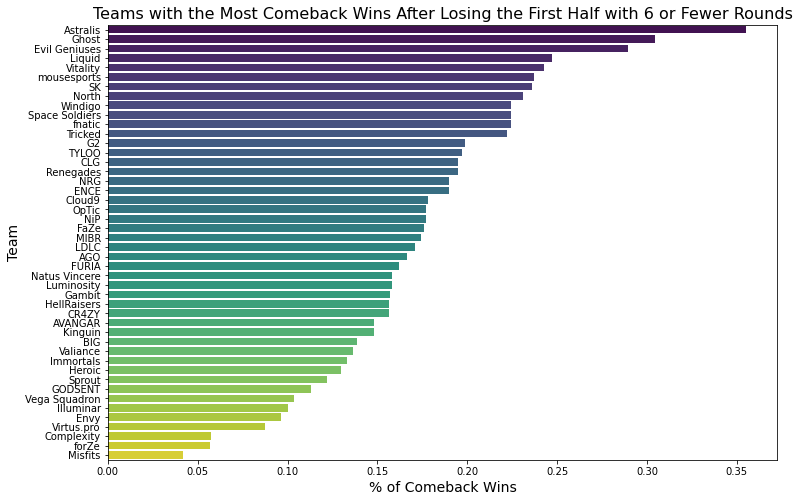

In [11]:
# Sort the teams by the number of comeback wins for better visualization
comeback_counts = comeback_stats[comeback_stats['total_comebacks']>=20].sort_values(by='win_fraction', ascending=False)

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create a bar plot for the number of comeback wins by each team
sns.barplot(x='win_fraction', y='possible_comeback_name', data=comeback_counts, palette='viridis')

# Add titles and labels
plt.title('Teams with the Most Comeback Wins After Losing the First Half with 6 or Fewer Rounds', fontsize=16)
plt.xlabel('% of Comeback Wins', fontsize=14)
plt.ylabel('Team', fontsize=14)

# Show the plot
plt.show()

Even here we see Astralis' complete dominance over everyone else. They won every third game if they started the second half of the game with 6 or fewer rounds taken. 

# is it true that if you start on the defensive side, you win more often? 

There's this assumption in Counter-strike that it's easier to start on the defense side. Perhaps it comes from the assumption of statistics, that defense wins more rounds than offense, and when you move to the second half, it is morally easier to take these 5-7 rounds than to comeback with a score of 6-9 or worse (that is, you already need to win 10+ rounds, which is psychologically difficult).

- Null Hypothesis (H0): Starting on the defense side does not significantly affect the winrate of a team.

- Alternative Hypothesis (H1): Starting on the defense side significantly affects the winrate of a team, suggesting that teams starting on the defense side win more often.

In [12]:
merged_results['ct_start_win'] = merged_results.apply(
    lambda row: 1 
    if row['starting_ct'] == row['map_winner'] else 0, axis=1)

merged_results['t_start_win'] = merged_results.apply(
    lambda row: 1 
    if row['starting_ct'] != row['map_winner'] else 0, axis=1)

# Calculate the winrate for teams starting on the defense/attack side
ct_start_winrate = merged_results['ct_start_win'].mean()


t_start_winrate = merged_results['t_start_win'].mean()

In [13]:
ct_start_win_count = merged_results['ct_start_win'].value_counts()[1]
total_games = len(merged_results['ct_start_win'])

In [14]:
binomtest(ct_start_win_count, total_games,alternative='greater')

BinomTestResult(k=2852, n=5643, alternative='greater', proportion_estimate=0.5054049264575581, pvalue=0.21222674432802155)

Since the p-value (0.2122) is greater than 0.05, we do not have sufficient evidence to reject the null hypothesis. This means that at the 0.05 significance level, we cannot conclude that the proportion of wins for the team that started on defense is significantly greater than 0.5.

In other words, the test results do not provide statistically significant evidence that starting on defense leads to a higher chance of winning. The proportion of wins for the defensive team (50.54%) is not different from 50% at the 0.05 significance level.

# The more games a team plays - the more often they win?


To test the hypothesis that the more often a team plays, the more often it wins (and thus the higher its winrate), we can use the Pearson correlation coefficient between the number of matches played and the winrate for each team by year.

- Null Hypothesis (H0): There is no significant correlation between the number of matches a team plays and its winrate. In other words, the number of matches played by a team does not have a significant impact on its winrate.

- Alternative Hypothesis (H1): There is a significant correlation between the number of matches a team plays and its winrate. In other words, the number of matches played by a team has a significant impact on its winrate.

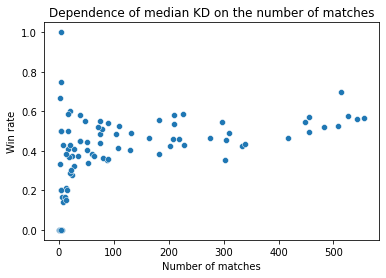

In [15]:
# Plot the dependence of median KD ratio on the number of matches
sns.scatterplot(x=team_stats['matches_played'], y=team_stats['winrate'])
plt.xlabel('Number of matches')
plt.ylabel('Win rate')
plt.title('Dependence of median KD on the number of matches')
plt.show()

In [16]:
teams=["Astralis",
"SK",
"Vitality",
"Liquid",
"Natus Vincere"]

remove noise in the data with teams up to 50 games

In [17]:
team_stats_withoit_noisy = team_stats[team_stats['matches_played']>=50]

In [18]:
# Conduct correlation analysis between the number of matches and winrate
corr_coef, p_value = pearsonr(team_stats_withoit_noisy[~team_stats_withoit_noisy['team_name'].
                                                       isin(teams)]['matches_played'], 
                              team_stats_withoit_noisy[~team_stats_withoit_noisy['team_name'].
                                                       isin(teams)]['winrate'])


# Display the results
print(f"Pearson Correlation Coefficient: {corr_coef}")
print(f"P-Value: {p_value}")

# Interpretation of results
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant correlation between the number of matches played and winrate.")
    if corr_coef > 0:
        print("The correlation is positive, indicating that the more a team plays, the higher its winrate.")
    else:
        print("The correlation is negative, indicating that the more a team plays, the lower its winrate.")
else:
    print("Fail to reject the null hypothesis. There is no significant correlation between the number of matches played and winrate.")

Pearson Correlation Coefficient: 0.4425546897965176
P-Value: 0.003763099587390476
Reject the null hypothesis. There is a significant correlation between the number of matches played and winrate.
The correlation is positive, indicating that the more a team plays, the higher its winrate.


- Pearson Correlation Coefficient: 0.442
- P-Value: 0.00376
##### Even without the five teams with the best winrate, we reject the null hypothesis. 
 - There is a significant correlation between the number of matches played and winrate. The correlation is positive, indicating that the more a team plays, the higher its winrate.
- Impact of Removing Top Teams
 - Context: Even after removing the five teams with the best winrate, the correlation remains significant.
 - Implication: The positive correlation between the number of matches played and winrate is robust. This is not only due to a few highly successful teams but is a more general trend across all teams.

_______________________________________________________________________________________________________


# Player statistics

In the player statistics, we will only look at players from matches in our resulting merged_results table.

### Our overall player statistics will include the following features:

- **date**: The date the match was played.
- **event_id**: A unique identifier for the tournament.
- **match_id**: A unique identifier for the match (a match between teams at a specific stage of the tournament, the same identifier regardless of the map).
- **kills**: The total number of kills by the player in the match.
- **deaths**: The total number of deaths of the player in the match.
- **kd_ratio**: Simply kills/deaths (there are no instances of deaths equal to 0 in the data).


Let's make the assumption that we will count the player's statistics not per map, but for the whole match. (1-3, sometimes 4-5 map per game)


In [19]:
# Filter the player DataFrame to include only the specified columns
player_filtered = players[['date','player_name', 'kills', 'deaths', 'event_id', 'match_id']]

# Merge the filtered player data with the cleaned merged results data
player_merged = pd.merge(
    player_filtered,
    merged_results[['event_id', 'match_id']],
    on=['event_id', 'match_id'],
    how='inner'
)
player_merged['date'] = pd.to_datetime(player_merged['date'])
player_merged['year'] = player_merged['date'].dt.year
player_merged = player_merged.drop_duplicates()

# Calculate K/D ratio
player_merged = player_merged.copy()
player_merged['kd_ratio'] = player_merged.apply(lambda row: row['kills'] / (row['deaths']), axis=1)


In [20]:
player_merged.head()

,date,player_name,kills,deaths,event_id,match_id,year,kd_ratio
0,2020-02-26,Brehze,57,61,4901,2339385,2020,0.934426
3,2020-02-26,CeRq,54,54,4901,2339385,2020,1.000000
6,2020-02-26,EliGE,55,51,4901,2339385,2020,1.078431
9,2020-02-26,Ethan,43,54,4901,2339385,2020,0.796296
12,2020-02-26,NAF,52,46,4901,2339385,2020,1.130435


In [21]:
player_stats = player_merged.groupby('player_name').agg(
    total_kills=('kills', 'sum'),
    total_deaths=('deaths', 'sum'),
    median_kd_ratio=('kd_ratio', 'median'),
    average_kd_ratio=('kd_ratio', 'mean'),
    match_count=('player_name', 'size'),
    std_kd_ratio=('kd_ratio', 'std'),
    var_kd_ratio=('kd_ratio', 'var')
).reset_index()


In [22]:
player_stats.sort_values(by='total_kills', ascending=False)

,player_name,total_kills,total_deaths,median_kd_ratio,average_kd_ratio,match_count,std_kd_ratio,var_kd_ratio
126,NiKo,11491,9414,1.222222,1.325275,356,0.543693,0.295602
44,EliGE,10667,9724,1.083673,1.146426,312,0.431026,0.185784
372,s1mple,10642,7509,1.441860,1.509203,271,0.537598,0.289011
370,ropz,10590,9069,1.170732,1.264020,339,0.670483,0.449548
363,rain,10342,9910,1.043478,1.133248,357,0.505946,0.255981
...,...,...,...,...,...,...,...,...
87,Jumpy,5,26,0.192308,0.192308,1,NaN,NaN
96,Krav,4,21,0.190476,0.190476,1,NaN,NaN
314,maLeK,3,4,0.750000,0.750000,1,NaN,NaN
27,Certus,3,4,0.750000,0.750000,1,NaN,NaN


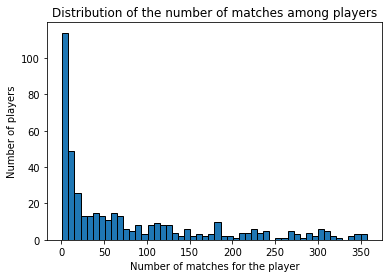

In [23]:
# Build a histogram of the number of matches among the players
plt.hist(player_stats['match_count'], bins=50, edgecolor='black')
plt.xlabel('Number of matches for the player')
plt.ylabel('Number of players')
plt.title('Distribution of the number of matches among players')
plt.show()

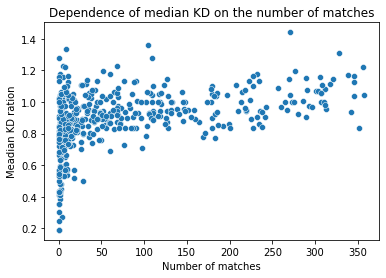

In [24]:
# Plot the dependence of median KD ratio on the number of matches
sns.scatterplot(x=player_stats['match_count'], y=player_stats['median_kd_ratio'])
plt.xlabel('Number of matches')
plt.ylabel('Meadian KD ration')
plt.title('Dependence of median KD on the number of matches')
plt.show()

###### as we can see - we have a large number of players with a small number of games and a large spread of median KD. Let's limit ourselves to data where the player has played 50 or more games. If a player has played more games - his statistic is not noise in the data, but his actual median statistic.

In [25]:
filtered_player_stats = player_stats[player_stats['match_count'] >= 50]

More games a player plays is a better median KD for him?
-----------------------------------------------------

In [26]:
filtered_player_stats

,player_name,total_kills,total_deaths,median_kd_ratio,average_kd_ratio,match_count,std_kd_ratio,var_kd_ratio
1,ALEX,4782,5076,0.953488,0.985621,147,0.333225,0.111039
3,ANGE1,5245,6072,0.849548,0.884970,192,0.306824,0.094141
5,AZR,6022,6644,0.894737,0.932832,225,0.304213,0.092546
7,AcilioN,1440,1683,0.853571,0.927109,54,0.398587,0.158872
8,AdreN,6202,6937,0.859155,0.910546,199,0.321279,0.103220
...,...,...,...,...,...,...,...,...
422,xms,2394,2676,0.897368,0.925904,108,0.352372,0.124166
423,xsepower,2519,2044,1.229032,1.416983,68,0.930403,0.865651
424,xseveN,3326,3719,0.883333,0.952957,111,0.358425,0.128469
426,yel,1496,1553,0.918129,0.999232,68,0.431685,0.186352


###### we can use the Pearson correlation coefficient to determine if there is a linear relationship between the number of games played and the median KD ratio.

Null Hypothesis (H0): There is no significant correlation between the number of games played and the median KD ratio of players. (the number of games played does not significantly affect the median KD ratio.)

Alternative Hypothesis (H1): There is a significant correlation between the number of games played and the median KD ratio of players.

- The Pearson correlation coefficient (corr_coef) indicates the strength and direction of the linear relationship between the two variables.
- The p-value indicates the statistical significance of the observed correlation.
- If the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a significant correlation between the number of games played and the median KD ratio.
- The sign of the correlation coefficient indicates whether the relationship is positive or negative.

In [27]:
# Calculate the Pearson correlation coefficient and p-value
corr_coef, p_value = pearsonr(filtered_player_stats['match_count'], filtered_player_stats['median_kd_ratio'])
# Display the results
print(f"Pearson Correlation Coefficient: {corr_coef}")
print(f"P-Value: {p_value}")

# Interpretation of results
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant correlation between the number of games played and the median KD ratio.")
    if corr_coef > 0:
        print("The correlation is positive, suggesting that players who play more games tend to have a better median KD ratio.")
    else:
        print("The correlation is negative, suggesting that players who play more games tend to have a worse median KD ratio.")
else:
    print("Fail to reject the null hypothesis. There is no significant correlation between the number of games played and the median KD ratio.")

Pearson Correlation Coefficient: 0.34612569584894703
P-Value: 7.67405392576744e-07
Reject the null hypothesis. There is a significant correlation between the number of games played and the median KD ratio.
The correlation is positive, suggesting that players who play more games tend to have a better median KD ratio.


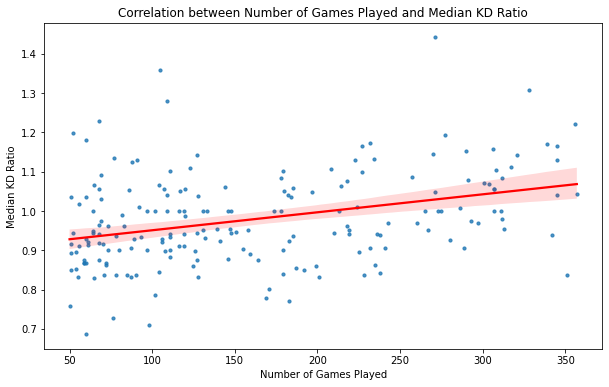

In [28]:
# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=filtered_player_stats['match_count'], y=filtered_player_stats['median_kd_ratio'], scatter_kws={'s':10}, line_kws={'color':'red'})
plt.xlabel('Number of Games Played')
plt.ylabel('Median KD Ratio')
plt.title('Correlation between Number of Games Played and Median KD Ratio')
plt.show()

### Pearson Correlation Coefficient: 0.346

- Strength and Direction: The Pearson correlation coefficient is 0.346, indicating a moderate positive correlation between the number of games played and the median KD ratio. This means that as the number of games played by a player increases, their median KD ratio tends to increase as well.
P-Value: 1.47e-21

### Statistical Significance: 
- The p-value is extremely low (7.67e-07), which is much smaller than the typical alpha level of 0.05. This indicates that the observed correlation is statistically significant and unlikely to have occurred by random chance.

### Conclusion
Based on the results of the Pearson correlation test, we can reject the null hypothesis that there is no significant correlation between the number of games played and the median KD ratio. Instead, we accept the alternative hypothesis that there is a significant positive correlation between these two variables. This could mean that the experience of playing on the pro scene improves your personal stats

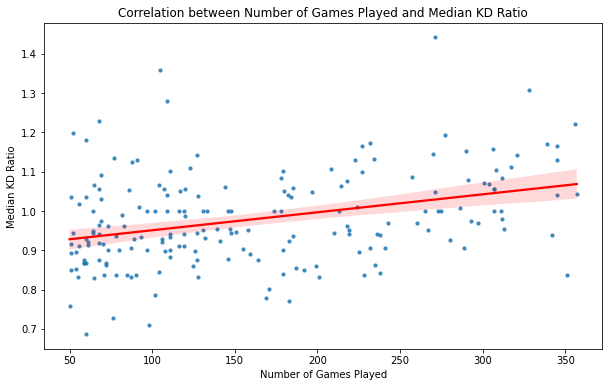

In [29]:
# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=filtered_player_stats['match_count'], y=filtered_player_stats['median_kd_ratio'], scatter_kws={'s':10}, line_kws={'color':'red'})
plt.xlabel('Number of Games Played')
plt.ylabel('Median KD Ratio')
plt.title('Correlation between Number of Games Played and Median KD Ratio')
plt.show()

###### So, who is the best player for all of our data?
- *is actually a very tricky and ambiguous question. But in our data we will limit ourselves only to the median KD of a player for all matches*

In [30]:
filtered_player_stats.sort_values(by='median_kd_ratio', ascending=False).head(10)

,player_name,total_kills,total_deaths,median_kd_ratio,average_kd_ratio,match_count,std_kd_ratio,var_kd_ratio
372,s1mple,10642,7509,1.441860,1.509203,271,0.537598,0.289011
194,ZywOo,4711,3553,1.360000,1.393757,105,0.443577,0.196761
236,device,10313,8104,1.308608,1.406620,328,0.617255,0.381003
81,Jame,4494,3521,1.281250,1.361289,109,0.528643,0.279464
423,xsepower,2519,2044,1.229032,1.416983,68,0.930403,0.865651
126,NiKo,11491,9414,1.222222,1.325275,356,0.543693,0.295602
196,acoR,2054,1739,1.197561,1.289811,52,0.424285,0.180018
225,coldzera,9163,7385,1.194444,1.348740,277,0.625536,0.391295
90,KSCERATO,2196,1788,1.180344,1.275414,60,0.438069,0.191905
247,electronic,8150,7029,1.174442,1.252612,232,0.556823,0.310052


Not surprisingly, it's S1mple. According to the player of the year awards (https://www.hltv.org/player/7998/s1mple), S1mple has been ranked like this: 
- 4 (2016)

- 8 (2017)

- 1 (2018)

- 2 (2019)

- 2 (2020)

- 1 (2021)

- 1 (2022)

- 7 (2023)

##### But it's interesting to find out the best player by comparing them to themselves on a year-to-year basis

In [31]:
player_stats_year = player_merged.groupby(['player_name','year']).agg(
    median_kd_ratio=('kd_ratio', 'median'),
    match_count=('player_name', 'size'),
    var_kd_ratio=('kd_ratio', 'var')
).reset_index()
filtered_player_list = set(filtered_player_stats['player_name'].to_list())

In [32]:
# match_count>=10 just to remove noisy data
player_stats_year[player_stats_year['match_count']>=10].sort_values(by='median_kd_ratio', ascending=False).head(10)

,player_name,year,median_kd_ratio,match_count,var_kd_ratio
850,s1mple,2018,1.500000,133,0.343926
851,s1mple,2019,1.409677,64,0.195234
849,s1mple,2017,1.357143,64,0.269051
550,device,2018,1.355042,166,0.368608
551,device,2019,1.333333,69,0.319131
525,coldzera,2017,1.322917,106,0.454057
852,s1mple,2020,1.322005,10,0.187673
448,ZywOo,2019,1.313725,91,0.194929
846,ropz,2019,1.307692,71,0.167647
194,Jame,2018,1.298148,22,0.731922


- Statistically, S1mple is competing against himself in terms of years than against other players...